In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
#inspecting table
inspector = inspect(engine)
inspector.get_table_names()

measurement_col = inspector.get_columns('measurement')
for columns in measurement_col:
    print (columns['name'], columns['type'])
    
    
station_col = inspector.get_columns('Station')
for columns in station_col:
    print(columns['name'], columns['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
#Checking first row of the data
first_row = session.query(Measurement).first()
print(first_row.__dict__)

#finding end_date using order_by date in descending order
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(end_date)

# date 1 year ago from end_date
date_year_ago = dt.date(2017, 8 ,23) - dt.timedelta(days=365)
print(date_year_ago)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001A73A8DA400>, 'tobs': 65.0, 'prcp': 0.08, 'station': 'USC00519397', 'date': '2010-01-01', 'id': 1}
('2017-08-23',)
2016-08-23


In [11]:
#Design a query to retrieve the last 12 months of precipitation data
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).\
        order_by(Measurement.date).all()


In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns =['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace = True)

# Sort the dataframe by date
sorted_prcp = prcp_df.sort_values(by ='Date')
sorted_prcp.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,1.45
2016-08-24,2.15


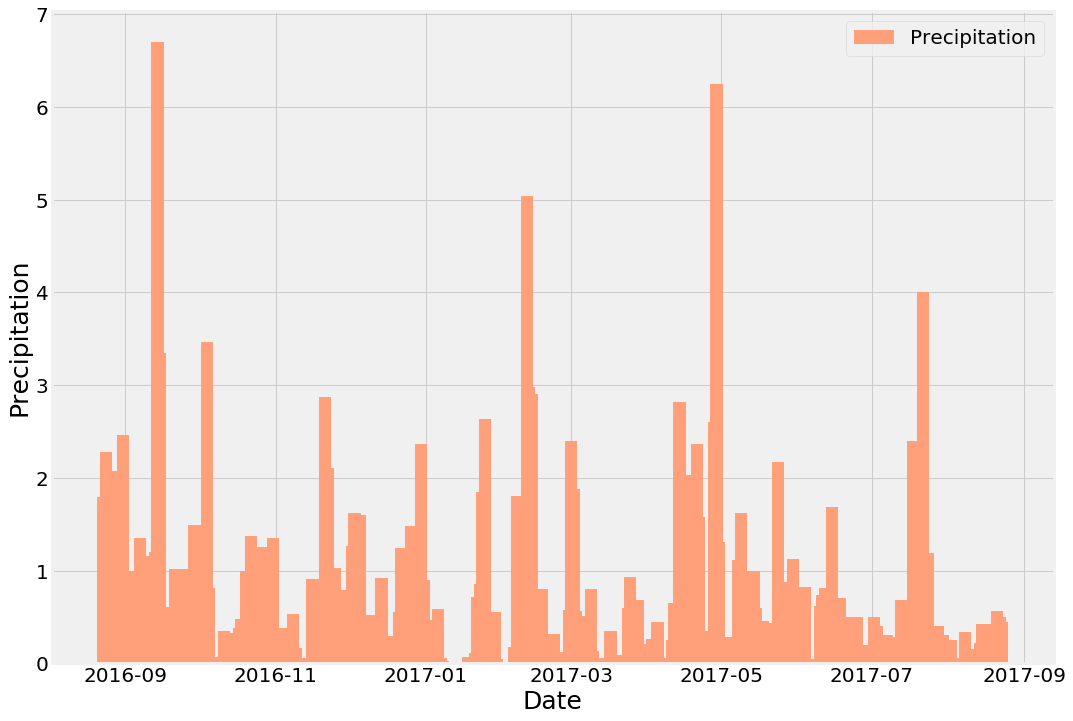

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

# Getting Data
Date = pd.to_datetime(sorted_prcp.index.values, format = '%Y-%m-%d')
Precipitation = sorted_prcp['Precipitation'].tolist()

# bar_plot (Date by precipitation)
fig, ax = plt.subplots(figsize = (16,12))

for label in (ax.get_xticklabels() +ax.get_yticklabels()):
    label.set_fontsize(20)

plt.bar(Date, Precipitation, color='lightsalmon', width = 5, label = 'Precipitation')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('Precipitation', fontsize = 25)
plt.legend(fontsize = 20, loc = 'best')


ax.grid(True)

plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_no = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_no)

9


In [16]:
# list of stations 
station_list = session.query(Measurement.station).group_by(Measurement.station).all()
print(station_list)

[('USC00511918',), ('USC00513117',), ('USC00514830',), ('USC00516128',), ('USC00517948',), ('USC00518838',), ('USC00519281',), ('USC00519397',), ('USC00519523',)]


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

from sqlalchemy import func 

active_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
                   group_by(Measurement.station).order_by((func.count(Measurement.tobs)).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station =='USC00519281').all()
station_temp

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_obs = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
                filter(Measurement.station =='USC00519281').\
                filter(Measurement.date >= date_year_ago).\
                group_by(Measurement.tobs).all()
#station_obs 

In [20]:
# Data prep to produce bargraph (tobs vs frequency)
tobs_df = pd.DataFrame(station_obs, columns =['Tobs', 'Frequency'])

# using bins to group the tobs data
bins = [58.5, 60.5, 62.5, 64.5, 66.5, 68.5, 70.5, 72.5, 74.5, 76.5, 78.5, 80.5, 83]
label = ['61', '63', '65', '67', '69', '71', '73', '75', '77', '79', '81', '83']
tobs_df['Tobs_group'] = pd.cut(tobs_df['Tobs'], bins, labels = label)

#converting the groupby-data to a Dataframe
frequency_grouped = pd.DataFrame(tobs_df.groupby(tobs_df['Tobs_group']).sum()['Frequency'])
frequency_grouped.head()

,Frequency
Tobs_group,
61,5
63,7
65,7
67,12
69,27


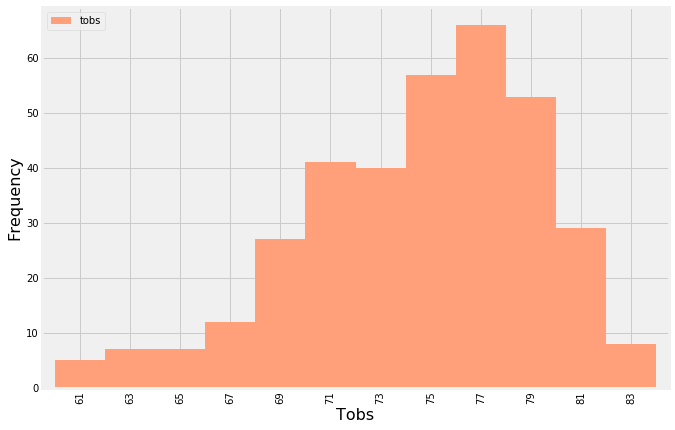

In [21]:
# bar graph
ax = frequency_grouped.plot.bar(width = 1, color= 'lightsalmon', figsize = (10, 7))
ax.set_xlabel('Tobs', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)
ax.legend(('tobs',), loc='upper left')
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-07-1', '2016-07-15'))

[(71.0, 77.1, 82.0)]


Text(0, 0.5, 'Temp (F)')

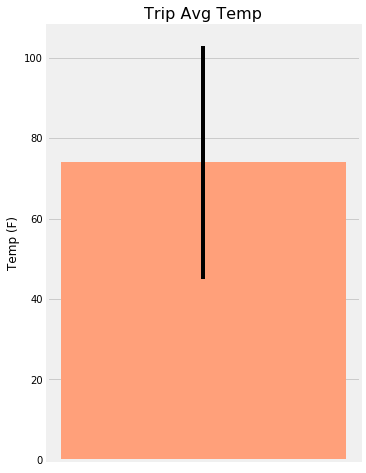

In [25]:
# Plot the results from your previous query as a bar chart. 
# Used the average temperature for the y value
# Used the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#data
err = 87.0-58
N = 1
x = np.arange(N)

# bar plot
fig, ax = plt.subplots(figsize = (5,8))
ax.bar(x, 74, color = 'lightsalmon', yerr = err)
ax.set_xticklabels(x, fontsize = 20)
ax.xaxis.grid()

plt.title ('Trip Avg Temp', fontsize =16)
plt.ylabel('Temp (F)', fontsize = 12)


In [26]:
# Calculated the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sorted this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

variables = Measurement.station, Station.name, Station.latitude, Station.longitude, Station. elevation, func.sum(Measurement.prcp)

station_join = session.query(*variables).group_by(Measurement.station).order_by((func.sum(Measurement.prcp)).desc()).\
                filter(Measurement.station==Station.station).\
                filter(Measurement.date >='2016-07-1').\
                filter(Measurement.date <='2016-07-15').all()

print(station_join)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.28), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.7800000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.01), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.86), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.48000000000000004), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [27]:
# Created a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
#creating list trip dates
start_date = dt.date(2016, 7, 1)
end_date = dt.date(2016, 7, 16)
dates = (start_date + dt.timedelta(days=x) for x in range(0,(end_date-start_date).days))

date_list=[]
for date in dates:
    date_list.append(date.strftime("%m-%d"))
    
for dates in date_list:
    trip_normals = (daily_normals(dates))
    datafile = pd.DataFrame(trip_normals, columns=("Min", "Max", "avg"))